In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from torchvision import transforms 
import torch
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import r2_score, mean_absolute_error
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms.functional as TF
import re
import glob
from PIL import Image, ImageDraw, ImageFont


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Define paths
img_dir = "/kaggle/input/wider-face-a-face-detection-dataset/WIDER_train/WIDER_train/images"
annotation_file = "/kaggle/input/wider-face-a-face-detection-dataset/wider_face_annotations/wider_face_split/wider_face_train_bbx_gt.txt"


# Data Exploration 



In [3]:
# Helper functions
def show_random_widerface_images(img_dir, annotation_file, num_images=5):
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
    
    i = 0
    count = 0
    while i < len(lines) and count < num_images:
        img_path = lines[i].strip()
        full_path = os.path.join(img_dir, img_path)
        if not os.path.exists(full_path):
            i += 1
            continue

        img = cv2.imread(full_path)
        if img is None:
            i += 1
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        face_count = int(lines[i + 1])
        for j in range(face_count):
            try:
                x, y, w, h = map(int, lines[i + 2 + j].split()[:4])
                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            except:
                continue

        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{face_count} faces - {img_path}")
        plt.show()

        i += 2 + face_count
        count += 1

def plot_face_count_distribution(annotation_file):
    counts = []
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
    i = 0
    while i < len(lines):
        try:
            face_count = int(lines[i + 1])
            counts.append(face_count)
            i += 2 + face_count
        except:
            i += 1
    
    plt.figure(figsize=(10, 5))
    sns.histplot(counts, bins=50)
    plt.title("Distribution of Face Counts per Image")
    plt.xlabel("Face Count")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()



--- Random Image Samples with Annotations ---


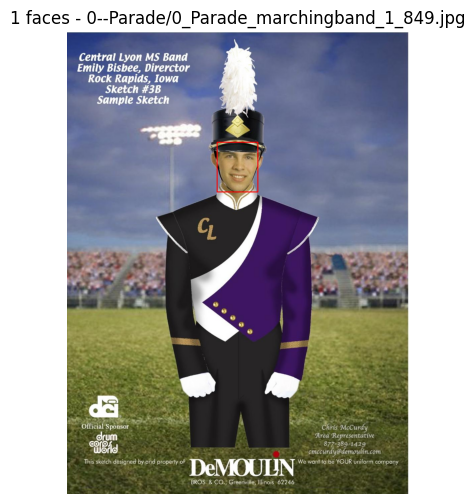

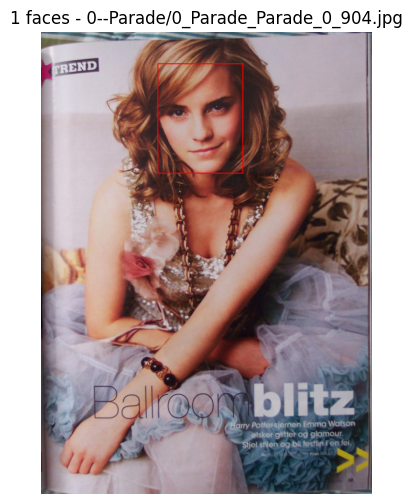

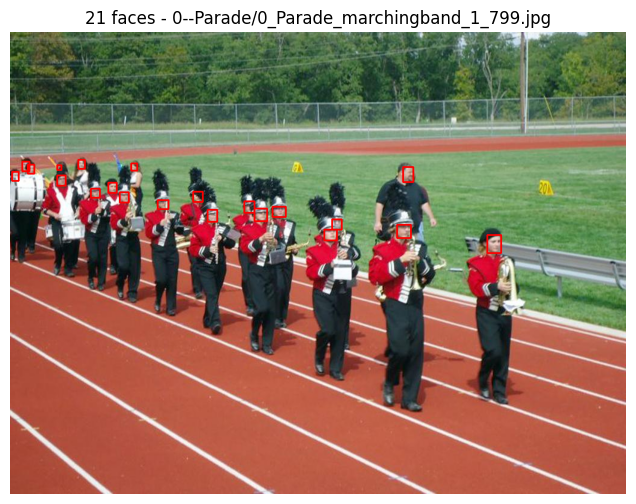

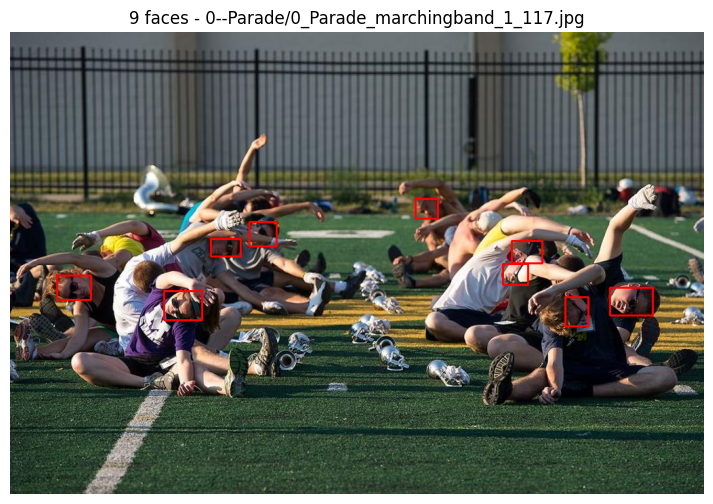

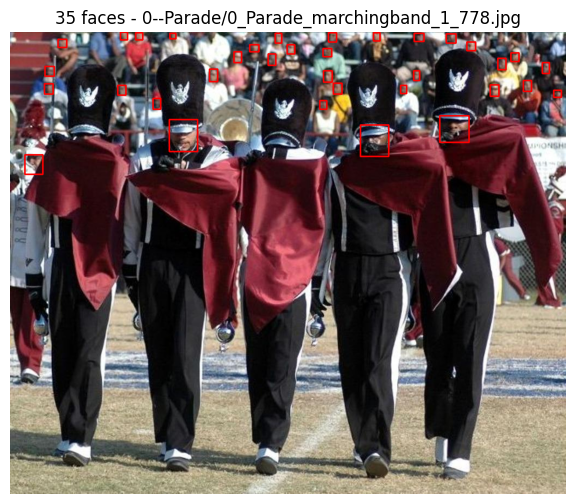

In [4]:
print("\n--- Random Image Samples with Annotations ---")
show_random_widerface_images(img_dir, annotation_file, num_images=5)



--- Face Count Distribution ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


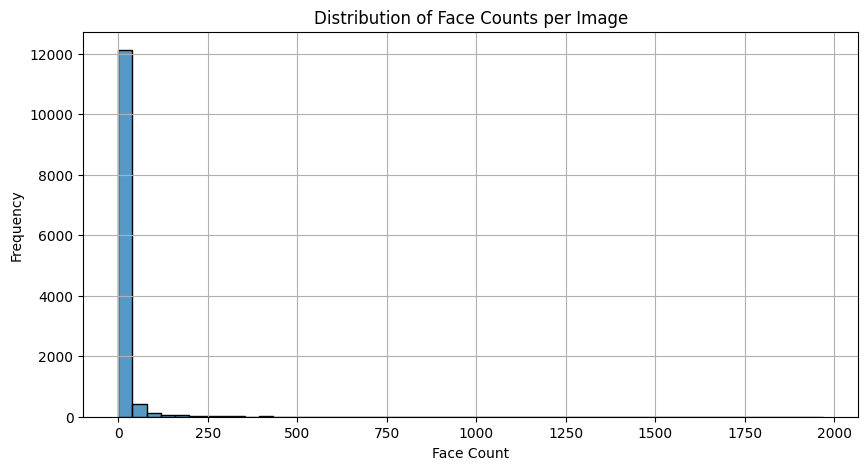

In [5]:
print("\n--- Face Count Distribution ---")
plot_face_count_distribution(annotation_file)

In [6]:
data = []

with open(annotation_file, 'r') as f:
    lines = f.readlines()

i = 0
while i < len(lines):
    line = lines[i].strip()
    
    if '--' in line and '.jpg' in line:
        image_rel_path = os.path.join(img_dir, line)
        i += 1
        num_faces = int(lines[i].strip())
        
        # Save to list
        data.append({
            'image_path': image_rel_path,
            'face_count': num_faces
        })
        
        # Skip bounding box lines
        i += num_faces
    else:
        i += 1

# Convert to DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('face_counts.csv', index=False)
print(f"Saved {len(df)} image entries with face counts to face_counts.csv")


Saved 12880 image entries with face counts to face_counts.csv


# Albumentation 

In [7]:

# Image size
IMAGE_SIZE = 224

# Training transforms
train_transforms = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


# Validation transforms (only resizing and normalization)
val_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Custom Dataset 

In [8]:
class FaceCountDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = cv2.imread(row['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        target = row['face_count']
        return image, torch.tensor(target, dtype=torch.float32), row['image_path']


 # Load face_counts.csv and Split with GroupKFold

In [9]:
# Load the face count data
df = pd.read_csv("face_counts.csv")
df['group'] = df['image_path'].apply(lambda x: os.path.normpath(x).split(os.sep)[-2])

# Create the GroupKFold splits
gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(df, groups=df['group']))

# Use one fold (example: fold 0)
train_idx, val_idx = splits[0]
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]


# Dataset Instances

In [10]:
# Create datasets
train_dataset = FaceCountDataset(train_df, transform=train_transforms)
val_dataset   = FaceCountDataset(val_df, transform=val_transforms)


# DataLoaders and Batching

In [11]:
# # Define batch size
# BATCH_SIZE = 32

# # Train DataLoader
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,             
#     num_workers=4,           
#     pin_memory=True           
# )

# # Validation DataLoader
# val_loader = DataLoader(
#     val_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,           
#     num_workers=4,
#     pin_memory=True
# )


In [12]:
import os
import pandas as pd

annotation_file = "/kaggle/input/wider-face-a-face-detection-dataset/wider_face_annotations/wider_face_split/wider_face_train_bbx_gt.txt"
img_dir = "/kaggle/input/wider-face-a-face-detection-dataset/WIDER_train/WIDER_train/images"
save_path = "train_annotations_retinaface.txt"
val_annotation_file = "/kaggle/input/wider-face-a-face-detection-dataset/wider_face_annotations/wider_face_split/wider_face_val_bbx_gt.txt"
val_img_dir = "/kaggle/input/wider-face-a-face-detection-dataset/WIDER_val/WIDER_val/images"
val_save_path = "val_annotations_retinaface.txt"
test_annotation_file = "/kaggle/input/wider-face-a-face-detection-dataset/wider_face_annotations/wider_face_split/wider_face_test_filelist.txt"
test_img_dir = "/kaggle/input/wider-face-a-face-detection-dataset/WIDER_test/WIDER_test/images"
test_save_path = "test_annotations_retinaface.txt"


def save_label_bounding_box(annotation_file, img_dir, save_path):
    with open(annotation_file, "r") as f:
        lines = f.readlines()
    
    i = 0
    entries = []
    while i < len(lines):
        line = lines[i].strip()
        
        if "--" in line and ".jpg" in line:
            image_rel_path = os.path.join(img_dir, line)
            i += 1
            try:
                num_faces = int(lines[i])
            except ValueError:
                print(f"⚠️ Skipping invalid image entry: {line}")
                # skip to next image line
                i += 1
                continue
    
            bboxes = []
            for j in range(num_faces):
                i += 1
                parts = lines[i].strip().split()
                if len(parts) < 4:
                    continue
                x, y, w, h = parts[:4]
                bboxes.append(f"{x},{y},{w},{h}")
    
            # Save in RetinaFace format
            if len(bboxes) > 0:
                entries.append(f"{image_rel_path} " + " ".join(bboxes))
        i += 1
    
    # Save annotation file
    with open(save_path, "w") as f:
        f.write("\n".join(entries))
    
    print(f"✅ Saved {len(entries)} annotated images to {save_path}")
save_label_bounding_box(annotation_file, img_dir, save_path)
save_label_bounding_box(val_annotation_file, val_img_dir, val_save_path)
# save_label_bounding_box(test_annotation_file, test_img_dir, test_save_path)


✅ Saved 12876 annotated images to train_annotations_retinaface.txt
✅ Saved 3226 annotated images to val_annotations_retinaface.txt
